# Model validation altimetry

Note: this notebook requires the model output data

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

In [1]:
import matplotlib.pyplot as plt
import modelskill as ms
import helper as h
import mikeio

In [2]:
obs_fldr = "../observations/" 
mr_fldr = "../output/"    
# mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
mr_fn = f"{mr_fldr}Area.dfsu"

save_png = False if "sample" in mr_fldr else True

In [3]:
altlist = h.get_altimetry_obs(quality=None)

In [4]:
mr = ms.DfsuModelResult(mikeio.read(mr_fn,time=slice("2022-01-03","2023-12-31"))[0], name="MIKE21")
mr

<DfsuModelResult>: MIKE21
Time: 2022-01-03 00:00:00 - 2023-12-31 23:00:00
Quantity: Surface Elevation [m]

In [5]:
cmps = []
match_t = "2023" # You can choose a specific time period here
for o in altlist:
    print(f"Processing {o.name}...")
    try:
        cmp = ms.match(obs=o.sel(time=match_t), mod=mr) 
        cmps.append(cmp.remove_bias())
    except Exception as e:
        print(e)    
cc = ms.ComparerCollection(cmps)

Processing 3a...
Processing 3b...
Processing 6a...
Processing c2...
Processing j3...
Processing sa...


In [6]:
cc.skill().round(4)

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
3a,14868,-0.0,0.1473,0.1473,0.1106,0.9867,0.2489,0.9659
3b,15697,0.0,0.1419,0.1419,0.1086,0.9896,0.2264,0.9723
6a,19484,-0.0,0.1305,0.1305,0.0994,0.9882,0.2214,0.9729
c2,15728,0.0,0.1482,0.1482,0.1108,0.9866,0.2370,0.9677
j3,18062,0.0,0.1300,0.1300,0.0987,0.9872,0.2317,0.9700
sa,13248,-0.0,0.1367,0.1367,0.1026,0.9878,0.2284,0.9705


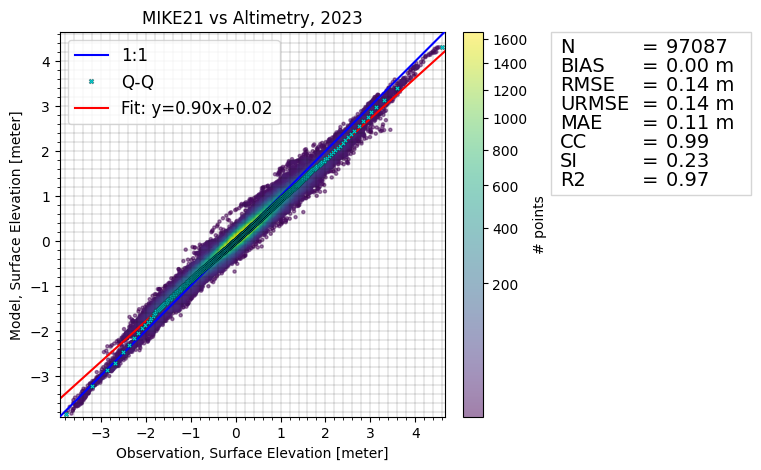

In [7]:
cc.plot.scatter(skill_table=True, show_points=True, figsize=(6,5))
plt.title("MIKE21 vs Altimetry, "+match_t)
if save_png: 
    plt.savefig("../figures/altimetry_comparison.png", bbox_inches="tight")

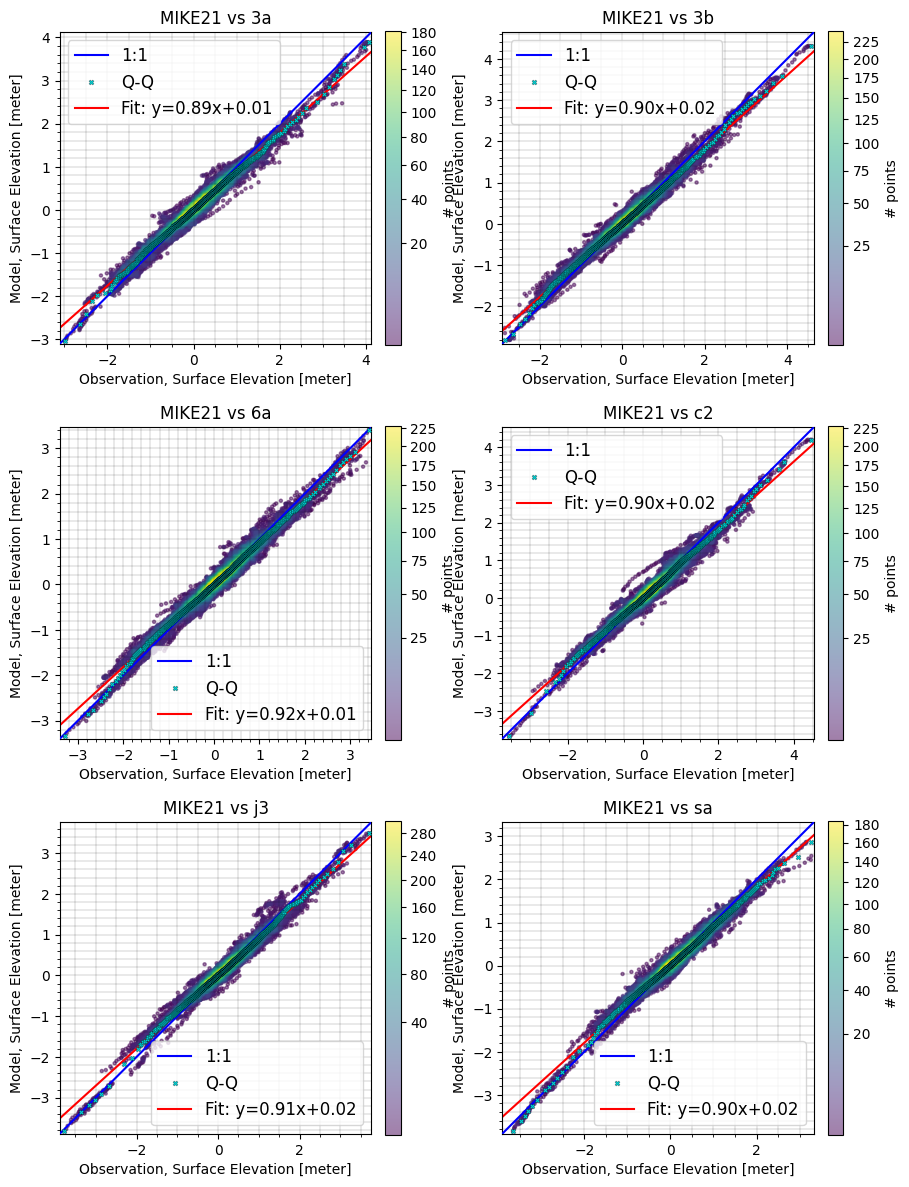

In [8]:
fig, axs = plt.subplots(-(-len(cc)//2), 2, figsize=(9,len(cc)*2))
axs = axs.flatten()
for i in range(len(cc)):
    cc[i].sel().plot.scatter(ax=axs[i], show_points=True)

if len(cc) % 2 != 0:
    axs[-1].axis("off")
plt.tight_layout()
plt.show()